
# Classificiation of software requirements using Deep Learning
**Example using PySpark and Horovod**

The paper [NoRBERT: Transfer Learning for Requirements Classification](https://ieeexplore.ieee.org/abstract/document/9218141) by Hey et. al. describes using BERT to classify requirements, with code available on [Hey's GitHub repo](https://github.com/tobhey/NoRBERT).

This notebook does mostly the same modeling, using a simpler coding strategy with [Keras](https://keras.io/) rather than [PyTorch](https://pytorch.org). Additional differences include:
* Regularization layers to reduce model overfitting
  * BatchNormalization
  * L2 regularization
* Class weights, to address imbalanced data
* Option to include under-represented class. (PO is dropped in paper.)

This resulting model has a better F1-score and may perform better on new data because of regularization.
* Average for all classes, F1-score = 100%
* Average when dropping PO class, F1-score = 100%

Hey et. al. shows the lower averages of 82% for BERT and 90% for Naive Bayes, in table V.

To understand the coding strategy, I recommend these resources:
* [Multi-class Text Classification using BERT and TensorFlow](https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d) for model metrics
* [TensorFlow Tutorial](https://youtu.be/5Ym-dOS9ssA) for an introduction to Keras and deep learning models
* [Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) Keras tutorial
* [Classify text with BERT](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb) Keras tutorial code

Distributed training in Spark using Horovod
* [Horovod on Spark](https://github.com/horovod/horovod/blob/master/docs/spark.rst)



* [Horovod with Keras](https://github.com/horovod/horovod/blob/master/docs/keras.rst)
* [Databricks example notebook](https://docs.databricks.com/machine-learning/train-model/distributed-training/horovod-spark.html)

![TensorFlow_model](https://www.tensorflow.org/static/site-assets/images/marketing/resources/models-hero.svg)


This notebook will have better performance with a GPU.

In [1]:
#@title Deep learning dependencies
# tensorflow, BERT and other models
# Reduce module conflicts (numpy, sklearn, tensorflow) by loading all at once...
%pip install -q -U pip
%pip install -q -U tensorflow tensorflow-text tf-models-official tensorrt "numpy<1.23" pandas==1.5.3 seaborn

from importlib.metadata import version
print(f"Tensorflow {version('tensorflow')}")
print(f"numpy {version('numpy')}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 20.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (se

In [2]:
#@title Tensorflow imports
import os
import shutil

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# from official.nlp import optimization  # to create AdamW optimizer
from tensorflow import keras

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

# print display options
pd.options.display.max_columns = None
pd.options.display.width=None
np.set_printoptions(linewidth=160)

# Text requirements Data
Dataset of labeled requirements (single sentences), each with one class of multiple classes

In [3]:
!wget -nc https://raw.githubusercontent.com/tobhey/NoRBERT/master/Code/Task1_to_3_original_Promise_NFR_dataset/promise_nfr.csv

--2023-07-06 21:55:19--  https://raw.githubusercontent.com/tobhey/NoRBERT/master/Code/Task1_to_3_original_Promise_NFR_dataset/promise_nfr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97495 (95K) [text/plain]
Saving to: ‘promise_nfr.csv’

promise_nfr.csv     100%[===================>]  95.21K  --.-KB/s    in 0.01s   

2023-07-06 21:55:20 (6.66 MB/s) - ‘promise_nfr.csv’ saved [97495/97495]



In [4]:
#@title Load the csv dataset

import pandas as pd

def load_data(filename):
    print(filename)
    df = pd.read_csv(filename, delimiter=';', header=0, encoding='utf8', names=['number', 'ProjectID', 'RequirementText', 'clazz', 'NFR', 'F', 'A', 'FT', 'L', 'LF', 'MN', 'O', 'PE', 'PO', 'SC', 'SE', 'US'])
    df = df.dropna()
    is_NFR = df['NFR']==1
    df = df[is_NFR]
    return df

pdf = load_data("promise_nfr.csv")

promise_nfr.csv


In [5]:
pdf.head()

,number,ProjectID,RequirementText,clazz,NFR,F,A,FT,L,LF,MN,O,PE,PO,SC,SE,US
0,1,1,The system shall refresh the display every 60 ...,PE,1,0,0,0,0,0,0,0,1,0,0,0,0
1,2,1,The application shall match the color of the s...,LF,1,0,0,0,0,1,0,0,0,0,0,0,0
2,3,1,If projected the data must be readable. On ...,US,1,0,0,0,0,0,0,0,0,0,0,0,1
3,4,1,The product shall be available during normal ...,A,1,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1,If projected the data must be understandable...,US,1,0,0,0,0,0,0,0,0,0,0,0,1


In [6]:
#@title Determine number of classes

print(pdf.groupby(['clazz'])['clazz'].count())

num_classes = pdf.groupby(['clazz'])['clazz'].count().shape[0]
print(f"Number of classes is {num_classes}")

clazz
A     21
FT    10
L     13
LF    38
MN    17
O     62
PE    54
PO     1
SC    21
SE    66
US    67
Name: clazz, dtype: int64
Number of classes is 11


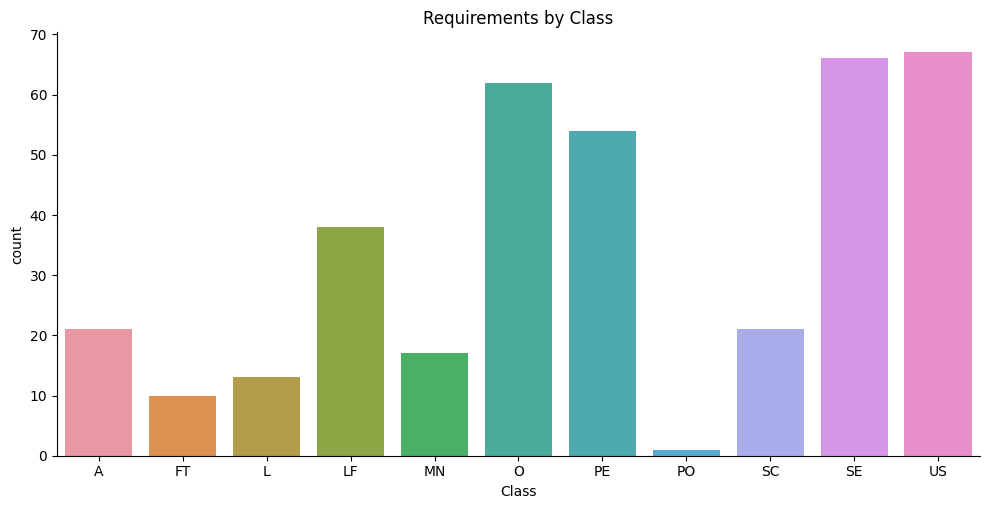

In [7]:
#@title Counts per class

import seaborn as sns

req_counts = pdf.groupby(['clazz'])['clazz'].count()
req_counts_df = pd.DataFrame({'Class':req_counts.index, 'count':req_counts.values})

sns.catplot(data=req_counts_df, x='Class', y='count', kind='bar', height=5, aspect=2).set(title='Requirements by Class');

## Replicate singleton class occurences

Replicate a classification (row) that only has one occurance. This allows for stratified n-fold validation, which cannot occur unless there is at least n occurences of each class.
* This introduces replicated text and its associated class
* Introducing n replicas, for a total of n+1 occurences, allows one to run stratified n+1 fold validation where each fold will have one instance of the text (like the original).

Set `num_min_class` to `-1` to use the original dataset.

In [8]:
# If num_min_class > 0, then replicate the row. If it == 0, then remove it. Otherwise, no change.
num_min_class = 0
col = 'clazz'
value = 'PO'


def replicate_class_rows(df: pd.DataFrame, col='clazz', value='PO', rep_num=3):
  """
  Replicate a row `rep_num` times and add to `df`.
  Applied to only one row to enable n-folds of cross validation.
  The result will be rep_num+1 rows that match the row with value.
  """
  rep_row = df.loc[df[col] == value].iloc[0]
  for i in range(0, rep_num):
    df.loc[len(df.index)] = rep_row
  return df

if num_min_class > 0:
  pdf = replicate_class_rows(pdf, col=col, value=value, rep_num=num_min_class)
elif num_min_class == 0:
  # remove the min class row(s)
  pdf = pdf[pdf[col]!=value]
else:
  print("No change to data.")

# # remove whitespace
# pdf['RequirementText'] = pdf['RequirementText'].str.strip()

pdf

,number,ProjectID,RequirementText,clazz,NFR,F,A,FT,L,LF,MN,O,PE,PO,SC,SE,US
0,1,1,The system shall refresh the display every 60 ...,PE,1,0,0,0,0,0,0,0,1,0,0,0,0
1,2,1,The application shall match the color of the s...,LF,1,0,0,0,0,1,0,0,0,0,0,0,0
2,3,1,If projected the data must be readable. On ...,US,1,0,0,0,0,0,0,0,0,0,0,0,1
3,4,1,The product shall be available during normal ...,A,1,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1,If projected the data must be understandable...,US,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,621,15,\tUser access should be limited to the permiss...,SE,1,0,0,0,0,0,0,0,0,0,0,1,0
621,622,15,\tThe product must comply with the intranet p...,LF,1,0,0,0,0,1,0,0,0,0,0,0,0
622,623,15,The intranet pages should display appropriate...,LF,1,0,0,0,0,1,0,0,0,0,0,0,0
623,624,15,\tThe users should be able to easily use the ...,US,1,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
#@title Update final number of classes

print(pdf.groupby(['clazz'])['clazz'].count())

num_classes = pdf.groupby(['clazz'])['clazz'].count().shape[0]
print(f"Number of classes is {num_classes}")

clazz
A     21
FT    10
L     13
LF    38
MN    17
O     62
PE    54
SC    21
SE    66
US    67
Name: clazz, dtype: int64
Number of classes is 10


In [10]:
#@title Encode text labels

from sklearn.preprocessing import LabelEncoder

# Save the (global) encoder so can convert back to label
le = LabelEncoder()

def categorical_encoder(pdf: pd.DataFrame, column: str, encoded_col: str) -> pd.DataFrame:
  pdf[encoded_col] = le.fit_transform(pdf[column])
  return pdf

data = categorical_encoder(pdf, 'clazz', 'label')[['RequirementText','label']]

Dataset as Pandas DataFrame. Ideally, this would be a Spark DataFrame. However, this is a minimal difference from the other example notebook that uses standard Python.

In [11]:
#@title sklearn data naming convention

X = data[['RequirementText']].rename(columns={'RequirementText': 'text'})
Y = data['label']

print(X)
print(Y)

                                                  text
0    The system shall refresh the display every 60 ...
1    The application shall match the color of the s...
2     If projected  the data must be readable.  On ...
3     The product shall be available during normal ...
4     If projected  the data must be understandable...
..                                                 ...
620  \tUser access should be limited to the permiss...
621   \tThe product must comply with the intranet p...
622   The intranet pages should display appropriate...
623   \tThe users should be able to easily use the ...
624   \tThe product interface should be fast. The r...

[369 rows x 1 columns]
0      6
1      3
2      9
3      0
4      9
      ..
620    8
621    3
622    3
623    9
624    6
Name: label, Length: 369, dtype: int64


In [12]:
#@title Specify class weights for imbalanced data

from sklearn.utils import class_weight
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
class_weights = dict(enumerate(compute_class_weight(y=Y, class_weight='balanced', classes=np.unique(Y))))
class_weights

{0: 1.7571428571428571,
 1: 3.69,
 2: 2.8384615384615386,
 3: 0.9710526315789474,
 4: 2.1705882352941175,
 5: 0.5951612903225807,
 6: 0.6833333333333333,
 7: 1.7571428571428571,
 8: 0.5590909090909091,
 9: 0.5507462686567164}

**When using weights, check with your optimizer**.


[Classification on imbalanced data](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

"Note: Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. **Optimizers whose step size is dependent on the magnitude of the**, like tf.keras.optimizers.SGD, **may fail**. The optimizer used here, tf.keras.optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models."

Consider [this dicussion](https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras)

# Prepare deep learning model

In [13]:
#@title Choose a BERT model to fine-tune ('bert_en_uncased_L-12_H-768_A-12')

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [14]:
#@title BERT preprocessing model

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [15]:
#@title Check text processing

text_test = [X['text'].iloc[0]]
print(f"input= {text_test}")
text_preprocessed = bert_preprocess_model(text_test)

input_len = 14

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :input_len]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :input_len]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :input_len]}')

input= ['The system shall refresh the display every 60 seconds.']
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1996  2291  4618 25416 21898  1996  4653  2296  3438  3823  1012   102     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
#@title Check BERT model

bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :input_len]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :input_len]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.8903908  -0.43810806 -0.9087886   0.740806    0.62208754 -0.17049731  0.78868324  0.3077737  -0.8385873  -0.99999464 -0.37114146  0.7784945   0.97290933
  0.67761093]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.42126948  0.10623559  0.34055787 ... -0.17598587  0.2253997   0.5916774 ]
 [ 0.19807754 -0.1198038  -0.4235121  ...  0.05902434  0.5624552   0.15061648]
 [ 0.372706    0.26509124  0.7034891  ... -0.7930526   0.1283738   0.64662355]
 ...
 [ 0.5467529   0.13915868 -0.0209008  ...  0.02838052 -0.63967526 -0.46334898]
 [ 0.48235285  0.1742544   0.17912291 ...  0.26146656 -0.642936   -0.3645628 ]
 [ 0.50697803  0.04031686  0.6510228  ... -0.06156011 -0.04571161  0.35858598]]


## BERT model similar to the NoRBERT model
Differences include:
* To reduce model overfitting, regularization layers including:
  * BatchNormalization
  * L2 regularization
* To address imbalanced dataset, class weights

In [17]:
from packaging import version

# Disable GPUs when building the model to prevent memory leaks
if version.parse(tf.__version__) >= version.parse('2.0.0'):
    # See https://github.com/tensorflow/tensorflow/issues/33168
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    keras.backend.set_session(tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})))

# Specify model

In [18]:
#@title Specify the BERT model with layer for multi-class classification

def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_preprocessor')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1, name='Dropout_1')(net)
  net = tf.keras.layers.BatchNormalization(name='BatchNorm')(net)
  # When dropping BatchNorm and regularization to mimic NORBERT, F1 score is similar (82%)
  # net = tf.keras.layers.Dense(64, name='Dense_64')(net)
  net = tf.keras.layers.Dense(64, name='Dense_64_reg_l2_01', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
  net = tf.keras.layers.Dense(num_classes, activation='softmax', name="classifier")(net)
  return tf.keras.Model(inputs=text_input, outputs=net, name="req_classifier")

model = build_model()

Model: "req_classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 BERT_preprocessor (KerasLa  {'input_word_ids': (None,    0         ['text[0][0]']                
 yer)                        128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                     

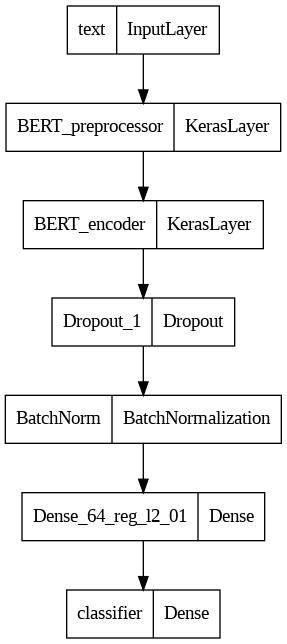

In [19]:
#@title Model summary

print(model.summary())
tf.keras.utils.plot_model(model)

In [20]:
# @title Check the model

bert_raw_result = model(tf.constant(text_test))
classification = tf.sigmoid(bert_raw_result)
# Convert back to label
clazz = le.inverse_transform([np.argmax(classification.numpy())])[0]
weight = classification.numpy()[0][np.argmax(classification.numpy())]
print(f"The classification of {text_test} is {clazz} with weight {weight:,.2f}")

The classification of ['The system shall refresh the display every 60 seconds.'] is LF with weight 0.62


In [21]:
# from google.colab import drive

# drive.mount('/content/drive')

In [22]:
#@title Save the model
# dataset_name = 'promise_nfr'
# saved_model_path = '/content/drive/MyDrive/{}_bert'.format(dataset_name.replace('/', '_'))

# model.save(saved_model_path, include_optimizer=False)

# Training the model (standard Python)

## Model reporting metrics

In [23]:
#@title Training parameters
configs = dict(
    num_classes = num_classes,
    batch_size = 32,
    earlystopping_patience = 3,
    learning_rate = 2e-4,
    epochs = 10,
    num_steps = 0.7,
)

In [24]:
#@title Model metrics

from keras import backend as K

# https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

In [25]:
#@title Cross validate model summary

def cv_summary(scores: pd.DataFrame):
  print("Summary of the cross validate epoch scores.")
  print(f"{'':<15.15}", end='')
  for n in scores.columns:
      print(f"{n:<15.14}", end='')
  print()
  values = list(scores[scores.columns].mean())
  print(f"{'mean':<15}", end='')
  for v in values:
    print(f"{v:<15,.4f}", end='')
  print()
  values = list(scores[scores.columns].std())
  print(f"{'std':<15}", end='')
  for v in values:
    print(f"{v:<15,.4f}", end='')
  print()


def model_scores(model, X_test, Y_test, verbose=0):
    scores = model.evaluate(X_test, Y_test, verbose=verbose)
    # Output various summaries
    for n,v in zip(model.metrics_names, scores):
      print(f"{n}={v*100:,.3f}%, ",  end='')
    print()
    return scores

In [26]:
#@title Classification metrics

from sklearn.metrics import classification_report

def report_classifications(model: tf.keras.Model, X: pd.Series, Y: pd.Series, num_classes: int):
  Y_pred = np.argmax(model.predict(X), axis=1)
  Y_true = np.argmax(tf.keras.utils.to_categorical(Y, num_classes=num_classes), axis=1)
  print("Summary of classifications")
  print(classification_report(Y_true, Y_pred))

In [27]:
#@title Epoch metrics, with graphing

def epoch_metrics(model_fit):
  metric_list = list(model_fit.history.keys())
  num_metrics = int(len(metric_list)/2)
  epochs_completed = len(model_fit.history[metric_list[0]])
  x = list(range(1, epochs_completed+1))

  fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

  for i in range(0, num_metrics):
    ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
    ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
    ax[i].set_xlabel("epochs",fontsize=14)
    ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
    ax[i].legend(loc="lower left")

  plt.show()

In [28]:
#@title Model cross validation (standard training)

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                      patience = configs['earlystopping_patience'],
                                                      restore_best_weights = True)


def cross_validate_model(model: tf.keras.Model, X: pd.Series, Y: pd.Series, num_classes: int, epochs: int, batch_size: int, n_folds=2, graph_scores=True):
  # fix random seed for reproducibility
  seed = 7
  np.random.seed(seed)

  cvscores = []
  if n_folds>1:
    # define n-fold cross validation test harness
    # maximum folds is minimum class count--class with only 1 record -> only 1 fold
    kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    for train, test in kfold.split(X, Y):
      print(f"Processing fold: {len(cvscores)+1}")
      # selected data folds
      Ytrain = tf.keras.utils.to_categorical(Y.iloc[train], num_classes=num_classes)
      Ytest = tf.keras.utils.to_categorical(Y.iloc[test], num_classes=num_classes)
      # fit the model
      model_fit = model.fit(X.iloc[train], Ytrain,
                            epochs=epochs, batch_size=batch_size,
                            class_weight= class_weights,
                            validation_data = (X.iloc[test], Ytest),
                            callbacks = [earlystop_callback])
      # evaluate the model using Keras (validate custom metrics)
      scores = model_scores(model, X.iloc[test], Ytest, verbose=0)
      cvscores.append(scores)
      if graph_scores:
        epoch_metrics(model_fit)
  else:
    print(f"Processing without folds")
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=seed)
    Ytrain = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
    Ytest = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
    # fit the model
    model_fit = model.fit(X_train, Ytrain,
                          epochs=epochs, batch_size=batch_size,
                          class_weight= class_weights,
                          validation_data = (X_test, Ytest),
                          callbacks = [earlystop_callback])
    # evaluate the model using Keras (validate custom metrics)
    scores = model_scores(model, X_test, Ytest, verbose=0)
    cvscores.append(scores)
    epoch_metrics(model_fit)

  pdf = pd.DataFrame(cvscores, columns = model.metrics_names)
  print()
  cv_summary(pdf)
  print()
  print("Final classifier")
  report_classifications(model, X, Y, num_classes)
  return model_fit, cvscores

## Training parameters

In [29]:
#@title Training parameters
configs = dict(
    num_classes = num_classes,
    batch_size = 32,
    earlystopping_patience = 3,
    learning_rate = 2e-4,
    epochs = 10,
    num_steps = 0.7,
)

In [30]:
#@title Training model optimizer

# Learning Rate
total_steps = len(data)*configs["epochs"]
decay_steps = total_steps * configs["num_steps"]

# https://wandb.ai/ayush-thakur/cosine_decay/reports/How-to-Use-Cosine-Decay-Learning-Rate-Scheduler-in-Keras--VmlldzozNTE4MDMy
cosine_decay_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = configs["learning_rate"],
    decay_steps = decay_steps,
    alpha=0.005
)

# https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy
# categorical_crossentropy because labels one-hot encoded and are soft probabilities
# from_logits=False (default) if last layer has activation function
loss_func = keras.losses.CategoricalCrossentropy(from_logits=False)


# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# Consider Adafactor, which uses less memory
optimizer = tf.keras.optimizers.AdamW(cosine_decay_scheduler)

model.compile(
    optimizer = optimizer,
    loss = loss_func,
    metrics = METRICS
)

## Run model (standard training)

Processing fold: 1
Epoch 1/10
9/9 [==============================] - 77s 1s/step - loss: 4.2127 - accuracy: 0.1667 - balanced_recall: 0.0600 - balanced_precision: 0.0972 - balanced_f1_score: 0.0688 - val_loss: 3.6330 - val_accuracy: 0.1613 - val_balanced_recall: 0.0000e+00 - val_balanced_precision: 0.0000e+00 - val_balanced_f1_score: 0.0000e+00
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 2.8578 - accuracy: 0.3732 - balanced_recall: 0.3096 - balanced_precision: 0.3917 - balanced_f1_score: 0.3434 - val_loss: 3.3148 - val_accuracy: 0.2366 - val_balanced_recall: 0.0333 - val_balanced_precision: 0.0333 - val_balanced_f1_score: 0.0333
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 1.7918 - accuracy: 0.7609 - balanced_recall: 0.6576 - balanced_precision: 0.7433 - balanced_f1_score: 0.6970 - val_loss: 2.5516 - val_accuracy: 0.5699 - val_balanced_recall: 0.2900 - val_balanced_precision: 0.5167 - val_balanced_f1_score: 0.3702
Epoch 4/10
9/9 [=======

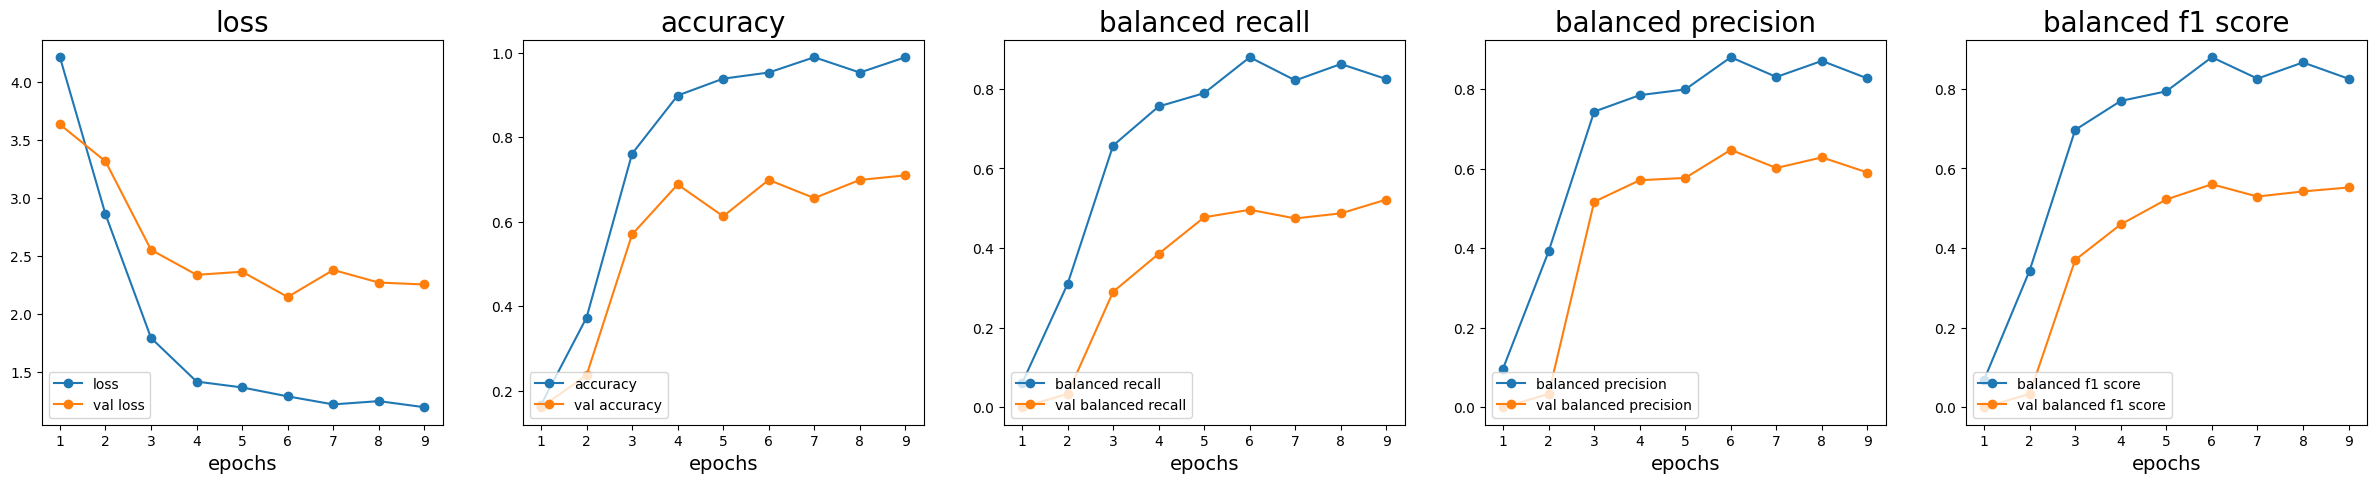

Processing fold: 2
Epoch 1/10
9/9 [==============================] - 9s 1s/step - loss: 1.6364 - accuracy: 0.8917 - balanced_recall: 0.7651 - balanced_precision: 0.7831 - balanced_f1_score: 0.7738 - val_loss: 1.6956 - val_accuracy: 0.9022 - val_balanced_recall: 0.6550 - val_balanced_precision: 0.7533 - val_balanced_f1_score: 0.6997
Epoch 2/10
9/9 [==============================] - 12s 1s/step - loss: 1.3393 - accuracy: 0.9278 - balanced_recall: 0.8624 - balanced_precision: 0.8665 - balanced_f1_score: 0.8640 - val_loss: 1.4365 - val_accuracy: 0.9457 - val_balanced_recall: 0.7867 - val_balanced_precision: 0.8486 - val_balanced_f1_score: 0.8164
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 1.2466 - accuracy: 0.9747 - balanced_recall: 0.8469 - balanced_precision: 0.8479 - balanced_f1_score: 0.8472 - val_loss: 1.3797 - val_accuracy: 0.9674 - val_balanced_recall: 0.7939 - val_balanced_precision: 0.8433 - val_balanced_f1_score: 0.8176
Epoch 4/10
9/9 [==================

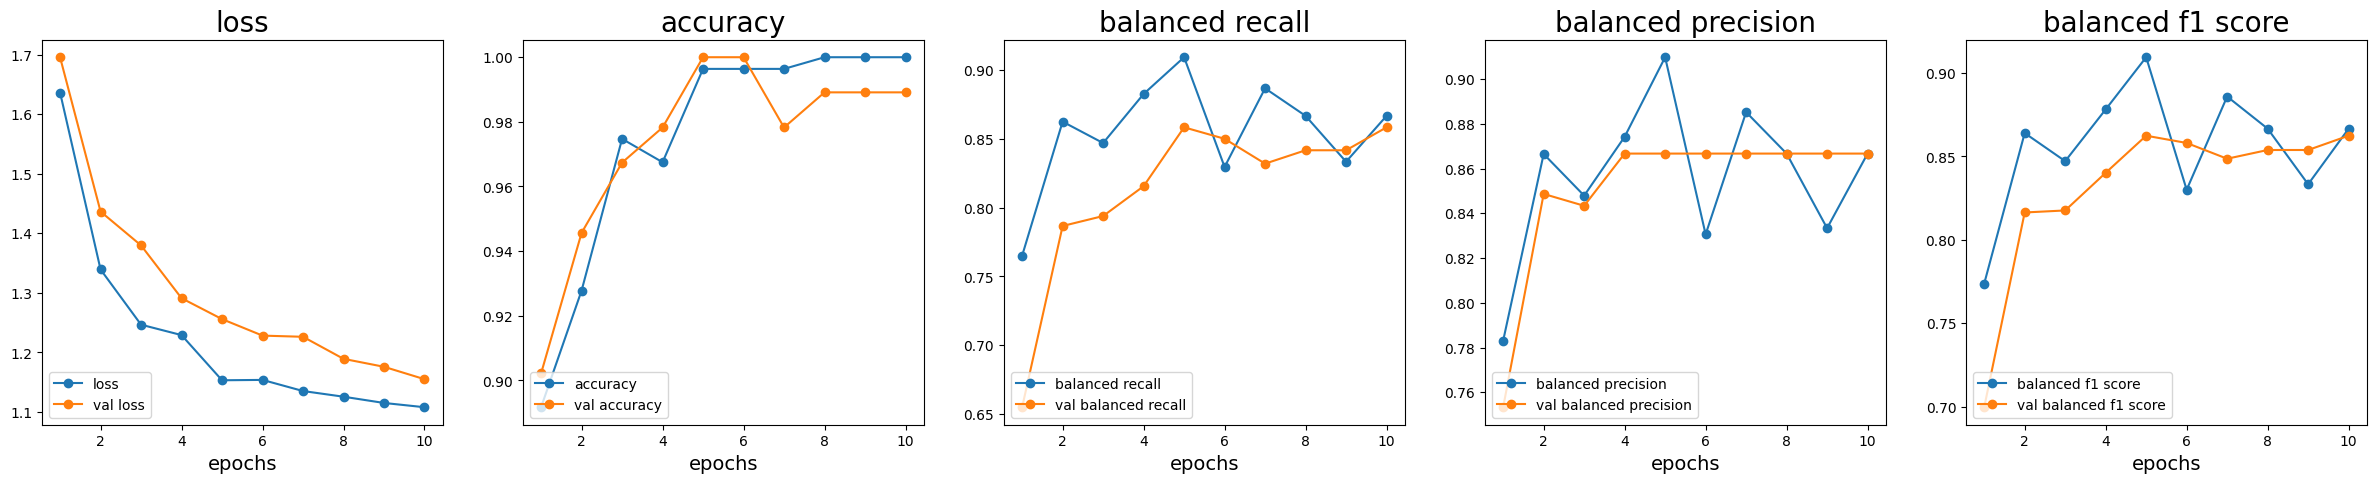

Processing fold: 3
Epoch 1/10
9/9 [==============================] - 10s 1s/step - loss: 1.1081 - accuracy: 0.9964 - balanced_recall: 0.8200 - balanced_precision: 0.8222 - balanced_f1_score: 0.8211 - val_loss: 1.1018 - val_accuracy: 1.0000 - val_balanced_recall: 0.8667 - val_balanced_precision: 0.8667 - val_balanced_f1_score: 0.8667
Epoch 2/10
9/9 [==============================] - 10s 1s/step - loss: 1.0990 - accuracy: 0.9964 - balanced_recall: 0.8542 - balanced_precision: 0.8537 - balanced_f1_score: 0.8539 - val_loss: 1.0936 - val_accuracy: 1.0000 - val_balanced_recall: 0.8667 - val_balanced_precision: 0.8667 - val_balanced_f1_score: 0.8667
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 1.0886 - accuracy: 1.0000 - balanced_recall: 0.8889 - balanced_precision: 0.8889 - balanced_f1_score: 0.8889 - val_loss: 1.0860 - val_accuracy: 1.0000 - val_balanced_recall: 0.8667 - val_balanced_precision: 0.8667 - val_balanced_f1_score: 0.8667
Epoch 4/10
9/9 [==================

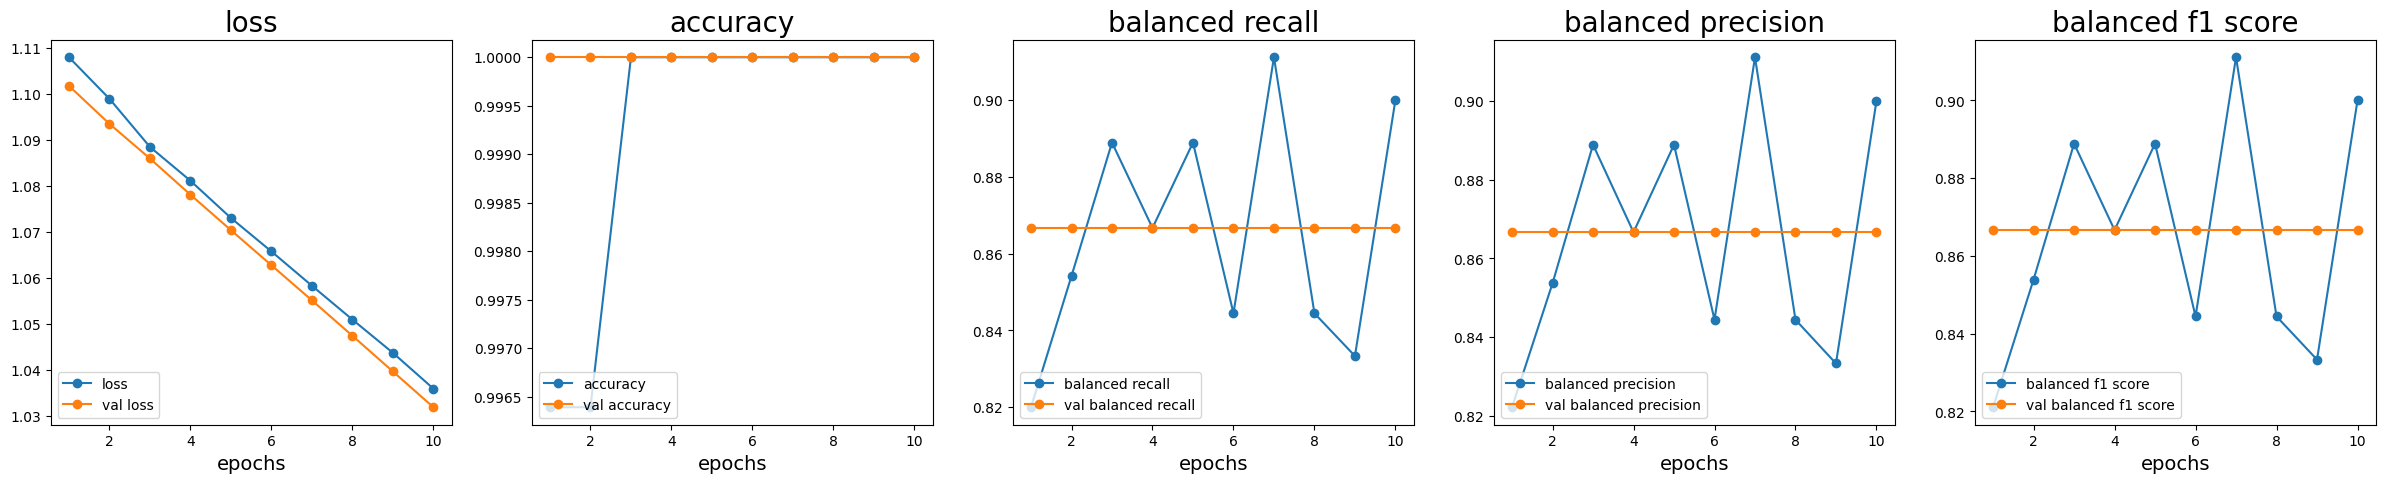

Processing fold: 4
Epoch 1/10
9/9 [==============================] - 10s 1s/step - loss: 1.0286 - accuracy: 1.0000 - balanced_recall: 0.8444 - balanced_precision: 0.8444 - balanced_f1_score: 0.8444 - val_loss: 1.0242 - val_accuracy: 1.0000 - val_balanced_recall: 0.8667 - val_balanced_precision: 0.8667 - val_balanced_f1_score: 0.8667
Epoch 2/10
9/9 [==============================] - 9s 1s/step - loss: 1.0207 - accuracy: 1.0000 - balanced_recall: 0.8444 - balanced_precision: 0.8444 - balanced_f1_score: 0.8444 - val_loss: 1.0163 - val_accuracy: 1.0000 - val_balanced_recall: 0.8667 - val_balanced_precision: 0.8667 - val_balanced_f1_score: 0.8667
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 1.0128 - accuracy: 1.0000 - balanced_recall: 0.8889 - balanced_precision: 0.8889 - balanced_f1_score: 0.8889 - val_loss: 1.0084 - val_accuracy: 1.0000 - val_balanced_recall: 0.8667 - val_balanced_precision: 0.8667 - val_balanced_f1_score: 0.8667
Epoch 4/10
9/9 [==================

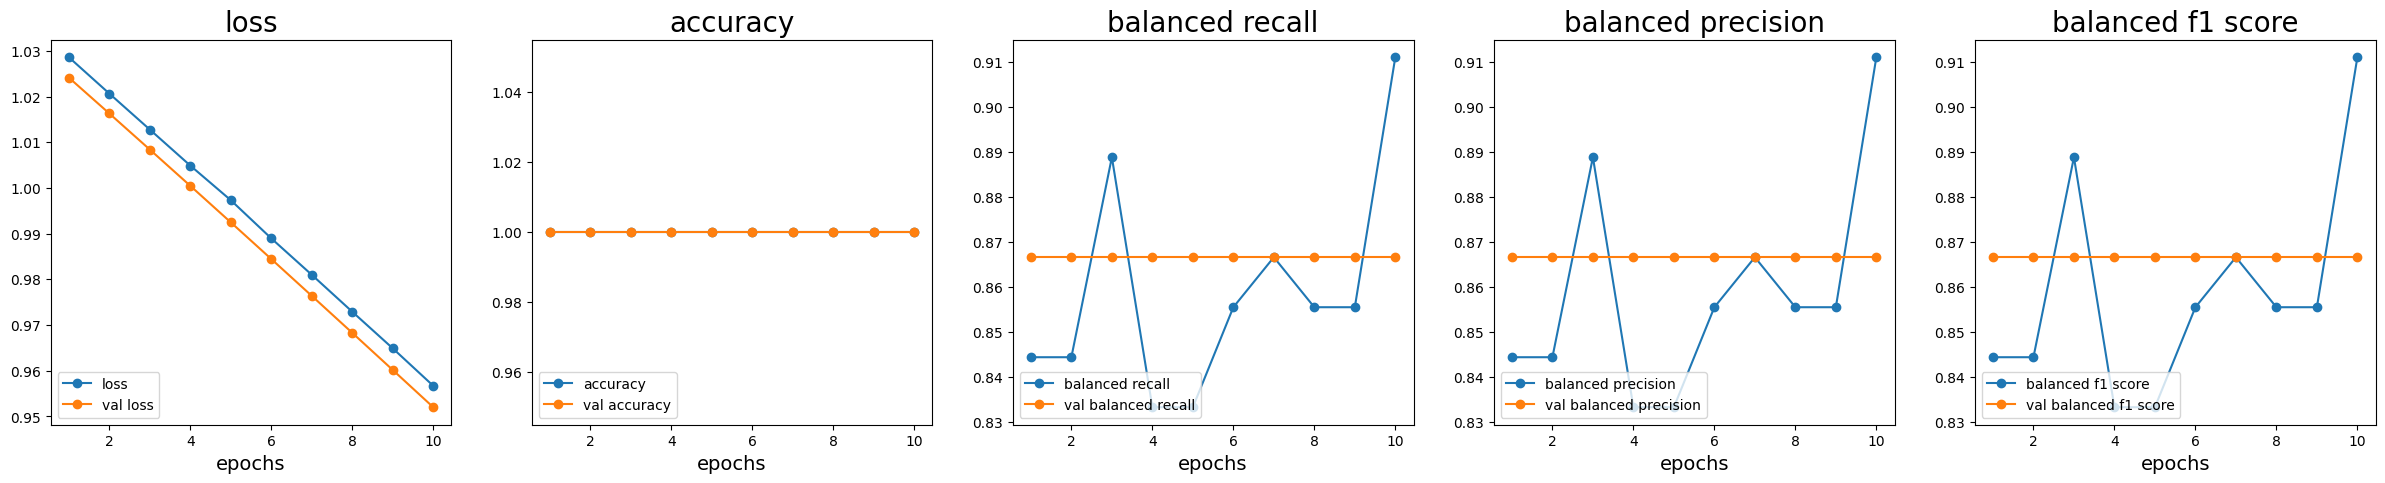


Summary of the cross validate epoch scores.
               loss           accuracy       balanced_recal balanced_preci balanced_f1_sc 
mean           1.3211         0.9220         0.7720         0.8118         0.7890         
std            0.5559         0.1488         0.1839         0.1097         0.1525         

Final classifier
12/12 [==============================] - 5s 330ms/step
Summary of classifications
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        38
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        62
           6       1.00      1.00      1.00        54
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00        66
           9       1.00      1.00      1.

In [31]:
#@title Run cross validation

model_fit, cvscores = cross_validate_model(model, X['text'], Y, configs['num_classes'], configs['epochs'], configs['batch_size'], n_folds=4, graph_scores=True)

## Export the model

In [32]:
# dataset_name = 'promise_nfr'
# saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

# model.save(saved_model_path, include_optimizer=False)

In [33]:
# from google.colab import drive

# drive.mount('/content/drive')

In [34]:
# dataset_name = 'promise_nfr'
# saved_model_path = '/content/drive/MyDrive/{}_bert'.format(dataset_name.replace('/', '_'))

# model.save(saved_model_path, include_optimizer=False)

## Predict with model

In [35]:
# reloaded_model = keras.models.load_model(saved_model_path)
# model = reloaded_model

In [36]:
# bert_raw_result = model(tf.constant(text_test))
# classification = tf.sigmoid(bert_raw_result)
# # Convert back to label
# clazz = le.inverse_transform([np.argmax(classification.numpy())])[0]
# weight = classification.numpy()[0][np.argmax(classification.numpy())]
# print(f"The classification of {text_test} is {clazz} with weight {weight:,.2f}")

In [ ]:
# bad_text = ["This is new text is not a requirement."]
# bert_raw_result = model(tf.constant(bad_text))
# classification = tf.sigmoid(bert_raw_result)
# # Convert back to label
# clazz = le.inverse_transform([np.argmax(classification.numpy())])[0]
# weight = classification.numpy()[0][np.argmax(classification.numpy())]
# print(f"The classification of {bad_text} is {clazz} with weight {weight:,.2f}")

# Spark model training

## Horovod
Now, run the training process in Spark using Horovod for TensorFlow training.

Horovod with Spark is new technology. Expect some issues.

Run the cells below with more memory. Ideally, > 24G per node.

In [12]:
#@title Spark context

%pip install -q pyspark findspark

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
print(f"Spark version: {spark.version}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Spark version: 3.4.1


In [13]:
df = spark.createDataFrame(data, schema=['text', 'label'])
df.show()

+--------------------+-----+
|                text|label|
+--------------------+-----+
|The system shall ...|    6|
|The application s...|    3|
| If projected  th...|    9|
| The product shal...|    0|
| If projected  th...|    9|
|The product shall...|    8|
|The product shall...|    9|
|The product shall...|    6|
|The look and feel...|    3|
| The user interfa...|    3|
|The system shall ...|    3|
|The product shall...|    3|
|The system shall ...|    9|
|The system shall ...|    9|
|The product shall...|    9|
|The product shall...|    9|
|The product shall...|    6|
|The search result...|    6|
|The product shall...|    6|
|The CMA report sh...|    6|
+--------------------+-----+
only showing top 20 rows



In [14]:
# TODO convert this into stratified and cross validate
# Train/test split
train_df, test_df = df.randomSplit([0.8, 0.2])

train_df.show(3)

+--------------------+-----+
|                text|label|
+--------------------+-----+
| All authorized u...|    8|
| If projected  th...|    9|
| Out of 1000 acce...|    0|
+--------------------+-----+
only showing top 3 rows



In [15]:
#@title Spark encoder

from pyspark.ml.feature import OneHotEncoder

# One-hot encode labels into SparseVectors
oh_encoder = OneHotEncoder(inputCols=['label'],
                        outputCols=['label_vec'],
                        dropLast=False)
oh_encoder_model = oh_encoder.fit(df)
encoded_df = oh_encoder_model.transform(df)

# TODO convert this into stratified and cross validate
# Train/test split
train_df, test_df = encoded_df.randomSplit([0.8, 0.2])

train_df.show(3)

+--------------------+-----+--------------+
|                text|label|     label_vec|
+--------------------+-----+--------------+
| All authorized u...|    8|(10,[8],[1.0])|
| If a user accoun...|    8|(10,[8],[1.0])|
| If projected  th...|    9|(10,[9],[1.0])|
+--------------------+-----+--------------+
only showing top 3 rows



In [16]:
!#@title Horovod Spark dependencies

# Wait until "Successfully installed horovod-" which can be about 10 minutes
# horovod depends on petastorm and must be explicitly loaded

# %pip install -q -U horovod[spark]==v0.27.0
%pip install -q -U horovod[spark]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.1 MB/s eta 0:00:00


In [17]:
import horovod
from importlib.metadata import version

print(f"horovod {version('horovod')}")
print(f"keras {version('keras')}")

horovod 0.28.1
keras 2.12.0


# Horovod approach to model fitting

* Memory is an issue with running Horovod. Ideally, use an image with at least 24G.
* Ensure that you select a small model, otherwise you're likely to have a out of memory error
  * E.g., select small_bert/bert_en_uncased_L-2_H-128_A-2

In [18]:
#@title Choose a BERT model to fine-tune ('bert_en_uncased_L-12_H-768_A-12')

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [19]:
#@title Specify the BERT model with layer for multi-class classification

def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='BERT_preprocessor')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1, name='Dropout_1')(net)
  net = tf.keras.layers.BatchNormalization(name='BatchNorm')(net)
  # When dropping BatchNorm and regularization to mimic NORBERT, F1 score is similar (82%)
  # net = tf.keras.layers.Dense(64, name='Dense_64')(net)
  net = tf.keras.layers.Dense(64, name='Dense_64_reg_l2_01', kernel_regularizer=tf.keras.regularizers.l2(0.01))(net)
  net = tf.keras.layers.Dense(num_classes, activation='softmax', name="classifier")(net)
  return tf.keras.Model(inputs=text_input, outputs=net, name="req_classifier")

small_model = build_model()

In [24]:
!#@title Train model using Horovod Spark

import horovod.spark.keras as hvd

from horovod.spark.common.store import Store
# Setup our store for intermediate data
store = Store.create("/tmp")


# Custom metrics, like above METRICS, reuqire more code to show with horovod
small_model.compile(optimizer = optimizer,
                  loss = loss_func,
                  metrics=['accuracy'])

# Only 2 for small demo image
num_proc=2

# Did not solve memory issue with large models
    # backend_env={"Xms": '3g', "Xms": '3g'},

# Must add custom_objects
CUSTOM_OBJECTS = {'KerasLayer':hub.KerasLayer, 'CaseFoldUTF8':text.case_fold_utf8,
                  'AdamW':tf.keras.optimizers.AdamW, 'Adafactor':tf.keras.optimizers.Adafactor,
                  'CosineDecay': tf.keras.optimizers.schedules.CosineDecay}

keras_estimator = hvd.KerasEstimator(
    num_proc=num_proc,
    store=store,
    model=small_model,
    custom_objects=CUSTOM_OBJECTS,
    optimizer=optimizer,
    loss=loss_func,
    feature_cols=['text'],
    label_cols=['label_vec'],
    metrics=['accuracy'],
    batch_size=configs['batch_size'],
    epochs=configs['epochs'],
    random_seed=1,
    verbose=1)

keras_model = keras_estimator.fit(train_df.repartition(num_proc)).setOutputCols(['label_prob'])

num_partitions=20
writing dataframes
train_data_path=file:///tmp/intermediate_train_data.0
val_data_path=file:///tmp/intermediate_val_data.0
train_partitions=20


/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:495: FutureWarning: 'ParquetDataset.schema' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.schema' attribute instead (which will return an Arrow schema instead of a Parquet schema).
  train_data_schema = train_data.schema.to_arrow_schema()
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:405: FutureWarning: 'ParquetDataset.pieces' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.fragments' attribute instead.
  for piece in dataset.pieces:
/usr/local/lib/python3.10/dist-packages/horovod/spark/common/util.py:513: FutureWarning: The 'field_by_name' method is deprecated, use 'field' instead
  metadata, avg_row_size = make_metadata_dictionary(train

train_rows=293


[1,0]<stderr>:2023-07-06 17:06:41.776188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[1,1]<stderr>:2023-07-06 17:06:41.785926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[1,0]<stdout>:Pinning current process to the GPU.
[1,0]<stdout>:Shared lib path is pointing to: <CDLL '/usr/local/lib/python3.10/dist-packages/horovod/tensorflow/mpi_lib.cpython-310-x86_64-linux-gnu.so', handle 652de70 at 0x7fec5a214070>[1,0]<stdout>:
[1,0]<stdout>:Training parameters: Epochs: 10, Scaled lr: 0.00039999998989515007, Shuffle: True, random_seed: 1
[1,0]<stdout>:Train rows: 293, Train batch size: 32, Train_steps_per_epoch: 5
[1,0]<stdout>:Val rows: 0, Val batch size: 32, Val_steps_per_epoch: None
[1,0]<stdout>:Checkpoint file: file:///tmp/runs/keras_1688663189, Logs dir: file:///tmp/runs/keras_1688663189/logs
[1,0]<stdout>:
[1,0]<stdout>:data_module: <class 'horovod.spark.keras.datamodule.PetastormDataModule'>[1,0]<stdout>:


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,0]<stderr>:  self._filesystem = pyarrow.localfs
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
[1,0]<stderr>:  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
[1,0]<stderr>:  if not dataset.common_metadata:
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/reader.py:420: FutureWarning: Specifying the 'metadata_nthreads' ar

[1,0]<stdout>:Epoch 1/10


[1,1]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/fs_utils.py:88: FutureWarning: pyarrow.localfs is deprecated as of 2.0.0, please use pyarrow.fs.LocalFileSystem instead.
[1,1]<stderr>:  self._filesystem = pyarrow.localfs
[1,1]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:402: FutureWarning: Specifying the 'metadata_nthreads' argument is deprecated as of pyarrow 8.0.0, and the argument will be removed in a future version
[1,1]<stderr>:  dataset = pq.ParquetDataset(path_or_paths, filesystem=fs, validate_schema=False, metadata_nthreads=10)
[1,1]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/etl/dataset_metadata.py:362: FutureWarning: 'ParquetDataset.common_metadata' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version.
[1,1]<stderr>:  if not dataset.common_metadata:
[1,1]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/reader.py:420: FutureWarning: Specifying the 'metadata_nthreads' ar

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 66s 12s/step - loss: 4.0723 - accuracy: 0.1719
[1,0]<stdout>:Epoch 2/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 39s 9s/step - loss: 2.5029 - accuracy: 0.5594
[1,0]<stdout>:Epoch 3/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 33s 8s/step - loss: 1.9086 - accuracy: 0.7531
[1,0]<stdout>:Epoch 4/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 37s 8s/step - loss: 1.5431 - accuracy: 0.8719
[1,0]<stdout>:Epoch 5/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 35s 8s/step - loss: 1.2850 - accuracy: 0.9594
[1,0]<stdout>:Epoch 6/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 37s 8s/step - loss: 1.2322 - accuracy: 0.9750
[1,0]<stdout>:Epoch 7/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 36s 8s/step - loss: 1.1800 - accuracy: 0.9937
[1,0]<stdout>:Epoch 8/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 35s 8s/step - loss: 1.1482 - accuracy: 1.0000
[1,0]<stdout>:Epoch 9/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 45s 10s/step - loss: 1.1452 - accuracy: 0.9937
[1,0]<stdout>:Epoch 10/10


[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/tf_utils.py:378: UserWarning: Running multiple iterations over make_petastorm_dataset is not recommend for performance issue. Use Reader's num_epochs contructor arguments to set number of iterations,or use tf.data.Dataset's cache() function to cache data of first iteration beforecalling 'repeat' method of Datset class.
[1,0]<stderr>:  warnings.warn(_RESET_READER_WARN, category=UserWarning)
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:140: FutureWarning: 'ParquetDataset.fs' attribute is deprecated as of pyarrow 5.0.0 and will be removed in a future version. Specify 'use_legacy_dataset=False' while constructing the ParquetDataset, and then use the '.filesystem' attribute instead.
[1,0]<stderr>:  parquet_file = ParquetFile(self._dataset.fs.open(piece.path))
[1,0]<stderr>:/usr/local/lib/python3.10/dist-packages/petastorm/arrow_reader_worker.py:288: FutureWarning: 'ParquetDataset.partit

[1,0]<stderr>:WARNING:absl:Found untraced functions such as _update_step_xla, restored_function_body, restored_function_body, restored_function_body, restored_function_body while saving (showing 5 of 65). These functions will not be directly callable after loading.


5/5 [==============================] - 24s 5s/step - loss: 1.1289 - accuracy: 1.0000


In [25]:
!#@title Check model results

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
import pyspark.sql.types as T

# Evaluate the model on the held-out test DataFrame
pred_df = keras_model.transform(test_df)
argmax = udf(lambda v: float(np.argmax(v)), returnType=T.DoubleType())
pred_df = pred_df.withColumn('label_pred', argmax(pred_df.label_prob))
evaluator = MulticlassClassificationEvaluator(predictionCol='label_pred', labelCol='label', metricName='accuracy')
print('Test accuracy:', evaluator.evaluate(pred_df))

Test accuracy: 0.5657894736842105
